# Learned Decoder
The purpose of this notebook is to investigate whether we can learn the MURA decoder

In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torchvision
import torchvision.transforms as transforms
import torch
from torch.utils.data import DataLoader

import wandb
import datetime
desktop_path = '/Users/jornelasmunoz/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/'
laptop_path = '/Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/'
if desktop_path in sys.path[0]: sys.path.insert(0, desktop_path + 'lib/'); path = desktop_path
elif laptop_path in sys.path[0]: sys.path.insert(0, laptop_path + 'lib/'); path = laptop_path
print('Using path = ', path)

from dataset import MNIST_MURA, FashionMURA
from utils.data import load_data
from utils.transforms import Noise_dB, Normalize_01
from reconstruct import RECON_CNN
# # Change plotting parameters
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "Times", #"Computer Modern Serif"
#     "figure.figsize" : [15,10],
# })

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Log into WandB
# wandb.login()

Using path =  /Users/jornelasmunoz/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/
Using cpu device


In [2]:
# Log into WandB for logging project training runs
wandb.login()

wandb: Currently logged in as: jocelynornelasmunoz. Use `wandb login --relogin` to force relogin


True

In [3]:
# Create params dict
date = str(datetime.datetime.now().date())
params = {
    "image_size": 23,
    "batch_size":100,
    "learning_rate": 0.001, 
    "epochs": 10,
    "model": f"decoder_cnn_{date}",
    "dataset": "MNIST_mura_noiseless",
    "scheduler_patience": 1,
    "snr": None,
    # "loss": None
}

if params['image_size'] != 23:
    params['model'] = f"decoder_cnn_{date}_{params['image_size']}x{params['image_size']}_{params['dataset']}"
wandb.config = params

# Load data
train_data, test_data, loaders = load_data(params)

Using the following parameters:
image_size: 23
batch_size: 100
learning_rate: 0.001
epochs: 10
model: decoder_cnn_2024-03-04
dataset: MNIST_mura_noiseless
scheduler_patience: 1
snr: None


In [5]:
from tqdm import tqdm

In [7]:
##### COMPUTE PIXEL SUM AND SQUARED SUM

# placeholders
psum    = torch.tensor([0.0])
psum_sq = torch.tensor([0.0])

# loop through images
for inputs in tqdm(loaders['train']):
    img, target, digits = inputs.values()
    psum    += img.sum()
    psum_sq += (img ** 2).sum()

100%|████████████████████████████████████████| 600/600 [00:01<00:00, 365.19it/s]


In [8]:
# pixel count
count = len(loaders['train']) * params['image_size'] * params['image_size']

# mean and STD
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

# output
print('Training data stats:')
print('- mean: {:.4f}'.format(total_mean.item()))
print('- std:  {:.4f}'.format(total_std.item()))

Training data stats:
- mean: 344.8359
- std:  nan


# Define Model

In [5]:
# Instantiate model 
model = RECON_CNN(params)#.to(device)
# model.apply(model.weights_init)

Using the following parameters:
image_size: 23
batch_size: 100
learning_rate: 0.001
epochs: 10
model: decoder_cnn_2024-03-04
dataset: MNIST_mura_noiseless
scheduler_patience: 1
snr: None
kernel_size: 23
loss: MSELoss()
model_save_path: ../runs/decoder_cnn_2024-03-0422222/decoder_cnn_2024-03-04.pth


../runs/decoder_cnn_2024-03-0422222
Initial weights Shape: torch.Size([1, 1, 23, 23])


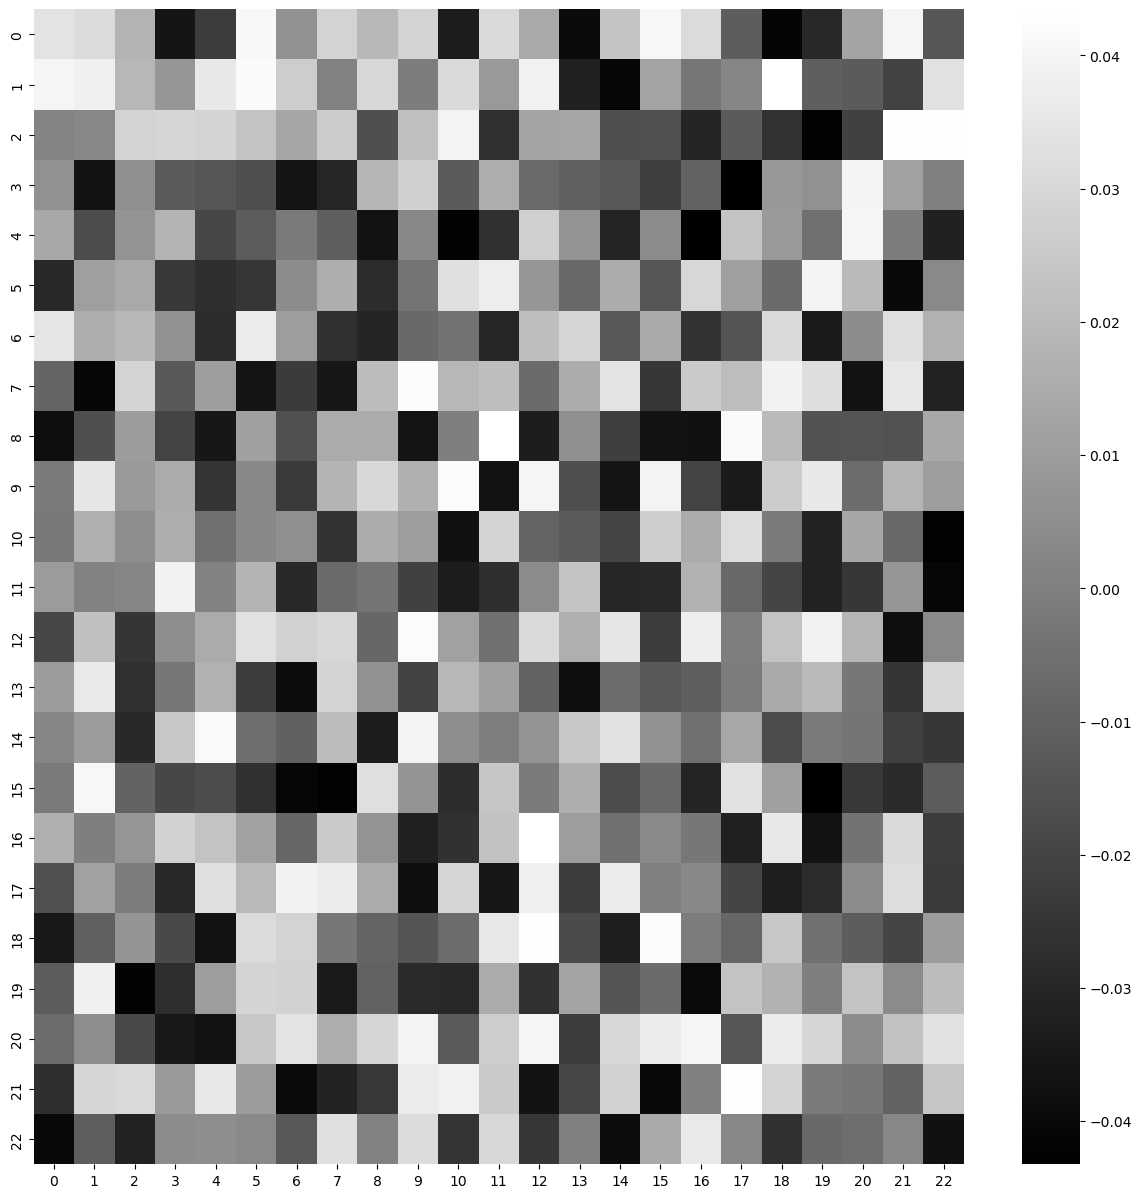

Target weights shape: torch.Size([23, 23])


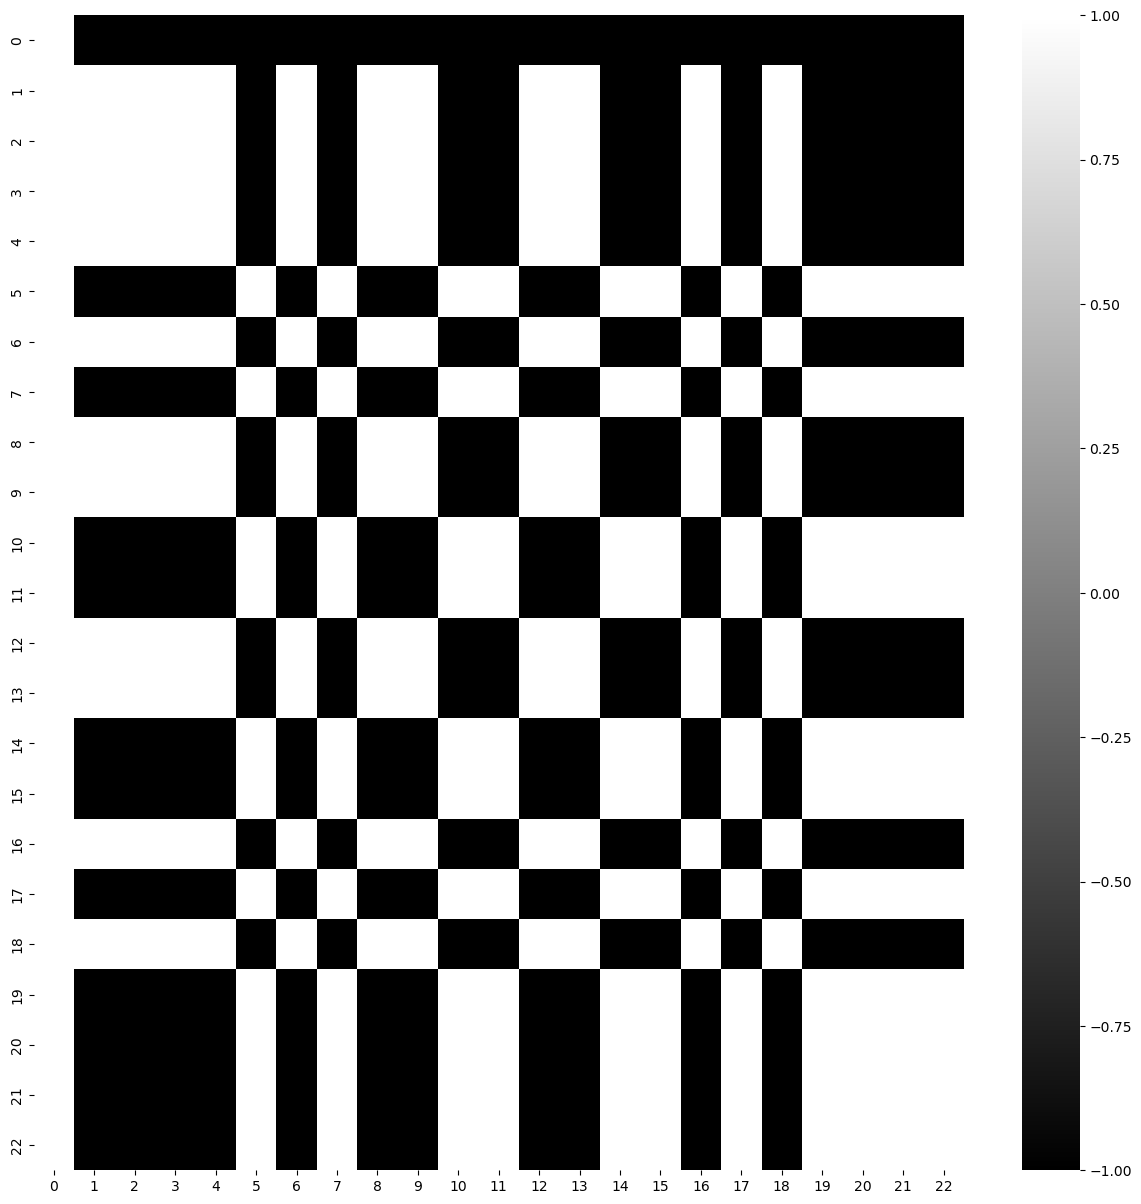

In [6]:
## Plot initial weights
# RUN_DIR = path+f'runs/{model.params["model"]}/'
# if not os.path.exists(RUN_DIR):
#     os.makedirs(RUN_DIR)
print(model.RUN_DIR)
# ----------- Plot initial weights and target weights---- 
# From Jacky's SAR stuff
# Define initial weights from the CNN model
init_weights = list(model.parameters())
init_weight_map = init_weights[0].detach()
print('Initial weights Shape: {}'.format(init_weights[0].shape))

# Plot initial weights
plt.figure(figsize=(15,15))
heat = sns.heatmap(np.squeeze(init_weight_map.cpu().numpy()), cmap='gray')
figure = heat.get_figure()
figure.savefig(model.RUN_DIR+f'/heat_init_weights.png',dpi=400)
#plt.close()
plt.show()

# Define and plot target weights
target_weights = train_data.G
print('Target weights shape: {}'.format(target_weights.shape))
plt.figure(figsize=(15,15))
heat = sns.heatmap(target_weights, cmap='gray')
figure = heat.get_figure()
figure.savefig(model.RUN_DIR+'/heat_target_weights.png',dpi=400)
#plt.close()
plt.show()

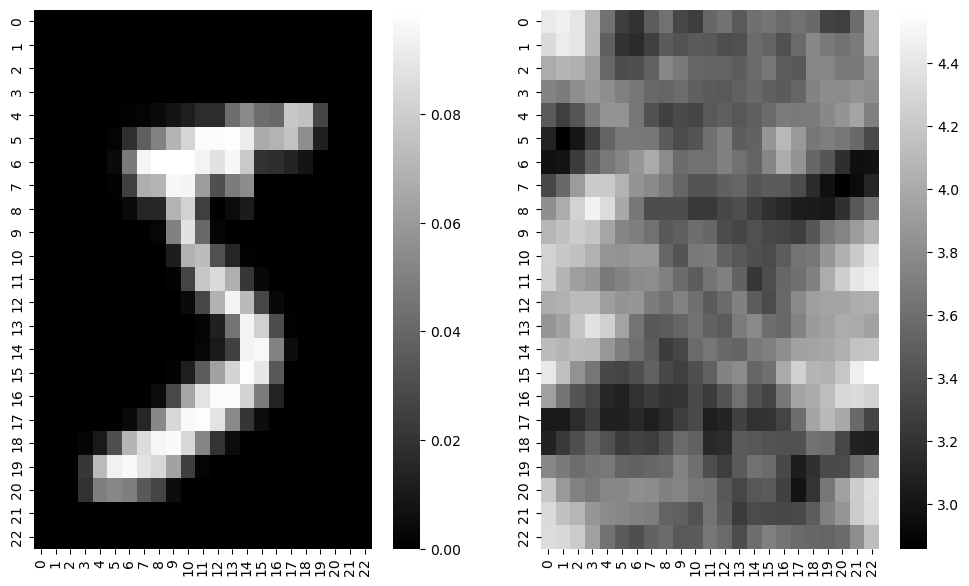

In [9]:
# Visualize data
fig, axs = plt.subplots(1,2, figsize=(12,7))
idx=0
sns.heatmap(loaders['train'].dataset[idx]['target'].squeeze(0), cmap= 'gray', ax=axs[0])
sns.heatmap(loaders['train'].dataset[idx]['img'].squeeze(0), cmap= 'gray', ax=axs[1])
# axs[0].axis('off')
# axs[1].axis('off')
plt.savefig(model.RUN_DIR+'/example.png', dpi=400)
plt.show()

# Training

In [7]:
%%time
# Initialize project in Weights and Biases
wandb.init(config=wandb.config, 
           project="ca-learned-decoder", 
           group=f"cnn_{params['image_size']}x{params['image_size']}", 
           name=str(datetime.datetime.now()))

# Store values for later 
train_loss = []
frob_per_epoch = []
weights_epoch = {}

#Dictionary that will store different images and outputs for various epochs (not sure if needed)
outputs = {}

# Training loop starts
for epoch in range(params['epochs']):
    
    # Initialize variable to store loss
    running_loss = 0
    model.train()
    # Iterate over training set
    for i, data in enumerate(loaders['train']):
        # zero the parameter gradients
        model.optimizer.zero_grad()
        
        # get the inputs; data is a dict of [images, labels, digit]
        inputs, targets, digits = data['img'], data['target'], data['digit']
            
        # Generate output
        out = model(inputs)
        
        # Calculate loss
        loss = model.criterion(out, targets)
        
        # # Modified (04/06/23) to include l_1 penalty
        # l_1_pen = sum((w.abs()-1).abs().sum() for w in model.parameters())
        # loss = loss + (model.params['lambda']/(model.params['p']**2)) * l_1_pen

        
        # Backprop and update weights
        loss.backward()
        model.optimizer.step()
        
        # Increment loss
        running_loss += loss.item()
        
    
    # Average loss over entire dataset
    running_loss/= len(loaders['train'].dataset)#params['batch_size']
    train_loss.append(running_loss)

    # Scheduler step every epoch
    model.scheduler.step(loss)
    
    print(f"Epoch {epoch +1} | Loss: {running_loss:.7f}")
    wandb.log({"epoch": epoch, "loss": running_loss, }) 
    
    # Storing images, reconstructed outputs, and labels
    outputs[epoch+1] = {'img': inputs, 'out': out, 'targets': targets, 'digits': digits}
    
    # Save weights every 2 epochs
    if epoch % 2 == 1:
        torch.save(model.state_dict(), model.params['model_save_path'])
        # epoch_save_model = path+f'models/CNN/{params["model"]}_model_epoch_'+str(epoch)+'.pth'
        # torch.save(model.state_dict(),epoch_save_model)
        weight_epoch_list = list(model.parameters())
        weights_epoch[f'{epoch}'] = np.squeeze(weight_epoch_list[0].detach().cpu().numpy())
        

    # Calculate Frobenius norm between weights and decoder every epoch
    weights = list(model.parameters())
    weight_map = np.squeeze(weights[0].detach().cpu().numpy())
    diff_block = train_data.G - weight_map
    frob_per_epoch.append(np.linalg.norm(np.abs(diff_block),ord='fro'))
    # weight_heatmap = sns.heatmap(weight_map, cmap='gray')
    # figure = weight_heatmap.get_figure()
    # figure.savefig(model.RUN_DIR+f'weights_epoch{epoch+1}.png',dpi=400)
#torch.save(model.state_dict(), PATH)
# End WandB run
wandb.finish()

Epoch 1 | Loss: 0.0006771
Epoch 2 | Loss: 0.0001056
Epoch 3 | Loss: 0.0000545
Epoch 4 | Loss: 0.0000330
Epoch 5 | Loss: 0.0000612
Epoch 6 | Loss: 0.0000700
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.
Epoch 7 | Loss: 0.0000403
Epoch 8 | Loss: 0.0000146
Epoch 9 | Loss: 0.0000131
Epoch 10 | Loss: 0.0000128


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▁▁▂▂▁▁▁▁
epoch,9
loss,1e-05


CPU times: user 6min 15s, sys: 2min 13s, total: 8min 28s
Wall time: 2min 23s


In [8]:
# Save model weights from last epoch
torch.save(model.state_dict(), model.RUN_DIR+f"{model.params['model']}.pth")

# Save weight progression
dict_path = model.RUN_DIR+'/weights_epoch.pkl'

import pickle
# Save weights dictionary to file
with open(dict_path, 'wb') as pickle_file:
    pickle.dump(weights_epoch, pickle_file)
print(f'Dictionary saved to {dict_path}')

# save frobenius per epoch
with open(model.RUN_DIR+'/frob_per_epoch.pkl', 'wb') as pickle_file:
    pickle.dump(frob_per_epoch, pickle_file)
print(f'Frobenius saved to {model.RUN_DIR+"/frob_per_epoch.pkl"}')

Dictionary saved to ../runs/decoder_cnn_2024-03-0422222/weights_epoch.pkl
Frobenius saved to ../runs/decoder_cnn_2024-03-0422222/frob_per_epoch.pkl


# Load model

In [13]:
# model.load_state_dict(torch.load('../models/learned_decoder_cnn/decoder_cnn.pth'))
# model.load_state_dict(torch.load(model.RUN_DIR+f"{model.params['model']}.pth"))

In [14]:
weight_map = list(model.parameters())[0].cpu().detach().squeeze(0).squeeze(0)

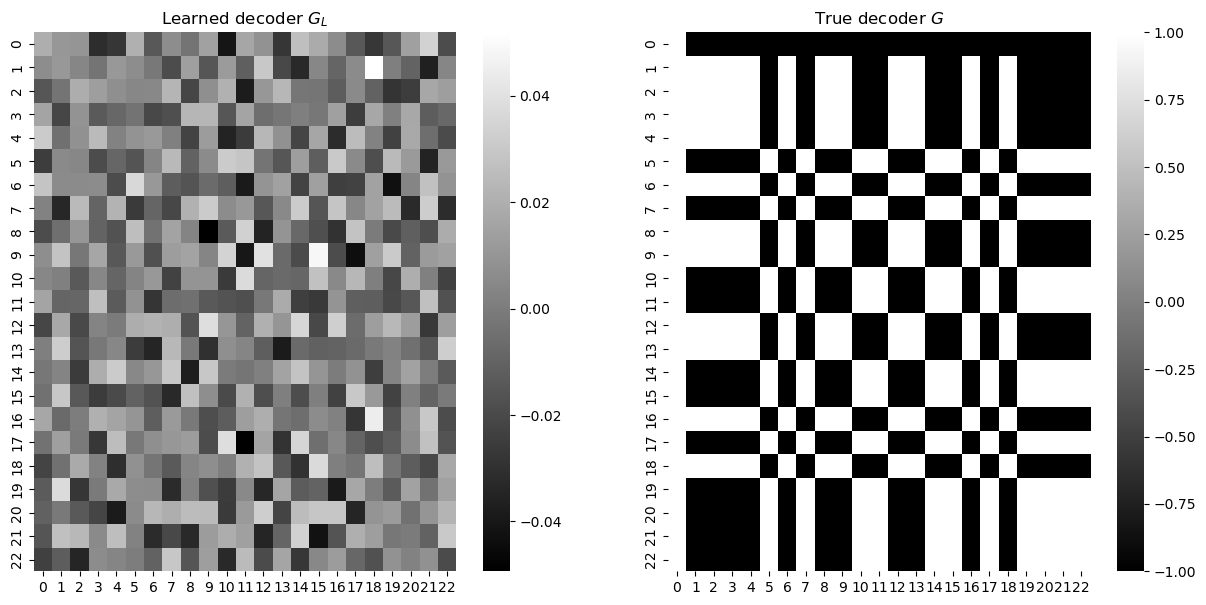

In [10]:
fig, axs = plt.subplots(1,2, figsize = (15,7))
sns.heatmap(weight_map, cmap='gray', ax=axs[0])
sns.heatmap(train_data.G, cmap='gray', ax=axs[1])

axs[0].set_title("Learned decoder $G_L$")
axs[1].set_title("True decoder $G$")
# fig.savefig('../figs/learned_decoder_cnn_47x47_20_epochs_circular_pad.png')
fig.savefig(model.RUN_DIR+'/heat_learned_weights.png',dpi=400)
plt.show()

# Test set evaluation

In [14]:
from torchmetrics.image import StructuralSimilarityIndexMeasure 

In [21]:
SSIM = StructuralSimilarityIndexMeasure()

In [23]:
model.params['snr'] = 'noiseless'
# Define transforms 
transform_list = transforms.Compose(
            [   transforms.Grayscale(),
                transforms.ToTensor(),
                transforms.Resize(params['image_size'], antialias=True),
                # Noise_dB(desired_snr=model.params['snr']),
                # transforms.Normalize(0, 1),
                Normalize_01(),
                ])
target_transform = transforms.Compose(
            [   transforms.Grayscale(),
                transforms.ToTensor(),
                transforms.Resize((params['image_size'],params['image_size']), antialias=True),
                Normalize_01(),
                ])

# Define test set
# test_mnist_mura = MNIST_MURA('../data/MNIST/', params, transform=transform_list, target_transform=target_transform, train=False)
test_mura = FashionMURA('../data/FashionMNIST/', params, transform=transform_list, target_transform=target_transform, train=False)
testset = DataLoader(test_mura, batch_size=100, shuffle=True)

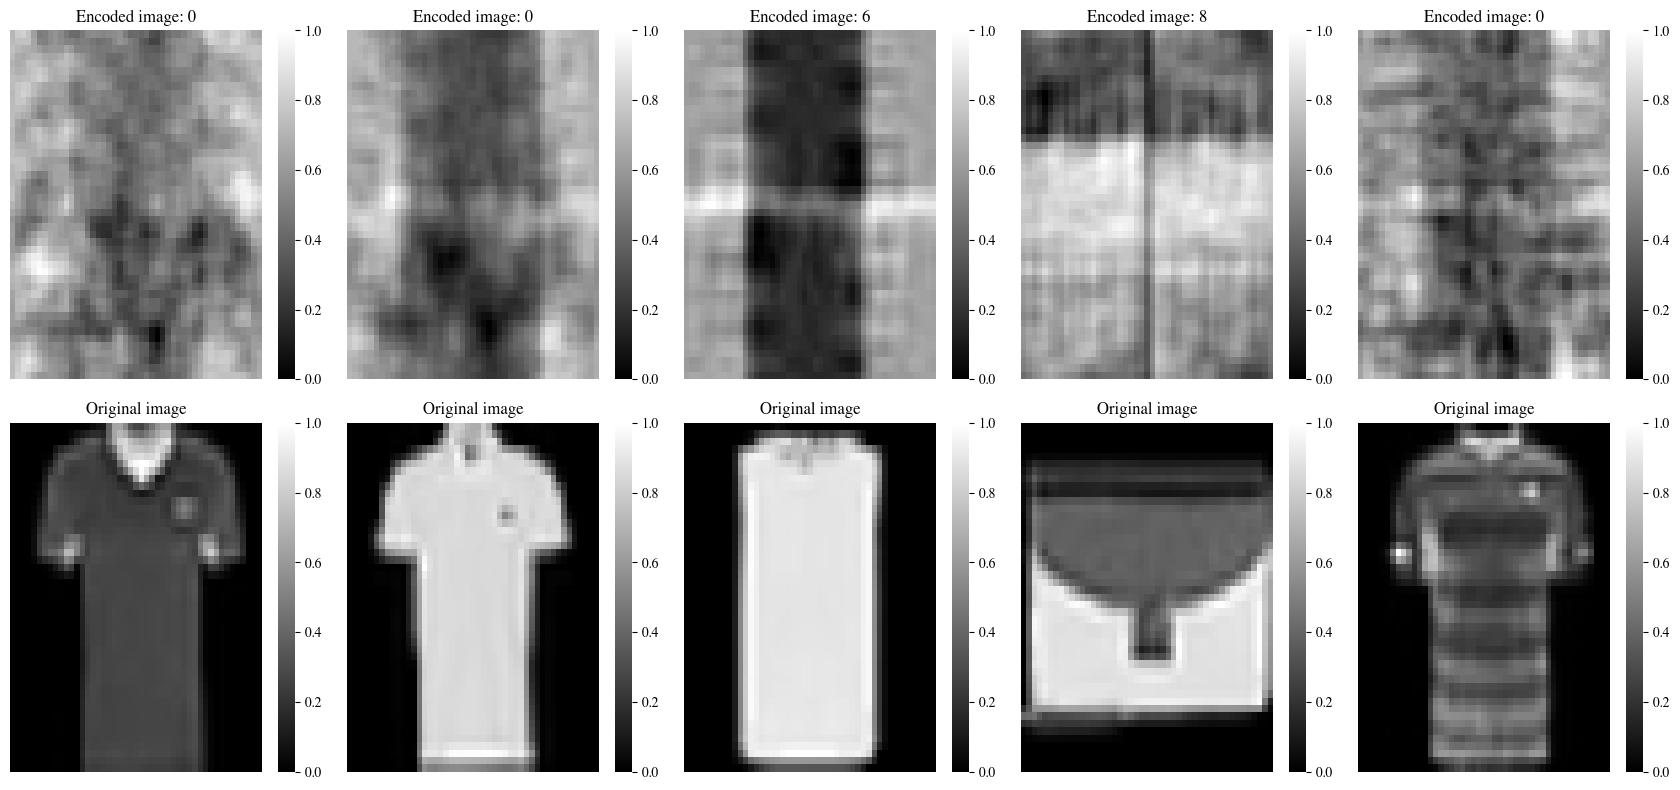

In [25]:
# Change plotting parameters
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "Times", #"Computer Modern Serif"
    "figure.figsize" : [17,8],
})
# Printing 25 random images from the test dataset
random_samples = np.random.randint(1, len(testset), (5))
count = 0
for idx in random_samples: #range(random_samples.shape[0]):
    plt.subplot(2, 5, count + 1)
    sns.heatmap(testset.dataset[idx]['img'].squeeze(0), cmap='gray')
    plt.title(f'Encoded image: {testset.dataset[idx]["digit"]}')
    plt.axis('off')
    plt.subplot(2, 5, count + 6)
    sns.heatmap(testset.dataset[idx]['target'].squeeze(0), cmap='gray')
    plt.title('Original image')
    plt.axis('off')
    
    count += 1
plt.tight_layout()
plt.savefig(model.RUN_DIR+ f"encoded_examples_snr_{model.params['snr']}.png")
plt.show()

In [26]:
results = []
for i, data in enumerate(testset):
    inputs, targets, digits = data['img'], data['target'], data['digit']
    outputs = model(inputs.to(device))
    mse_loss = model.criterion(outputs, targets)
    ssim_loss = SSIM(outputs, targets)
    results.append((inputs, outputs, targets, digits, mse_loss.item(), ssim_loss.item()))
    # show_outputs(outputs, targets, inputs, iterator=i)

In [27]:
df = pd.DataFrame(results, columns=['inputs', 'outputs', 'targets', 'digits', 'mse', 'ssim'])

In [28]:
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
# pio.renderers.default = 'notebook'

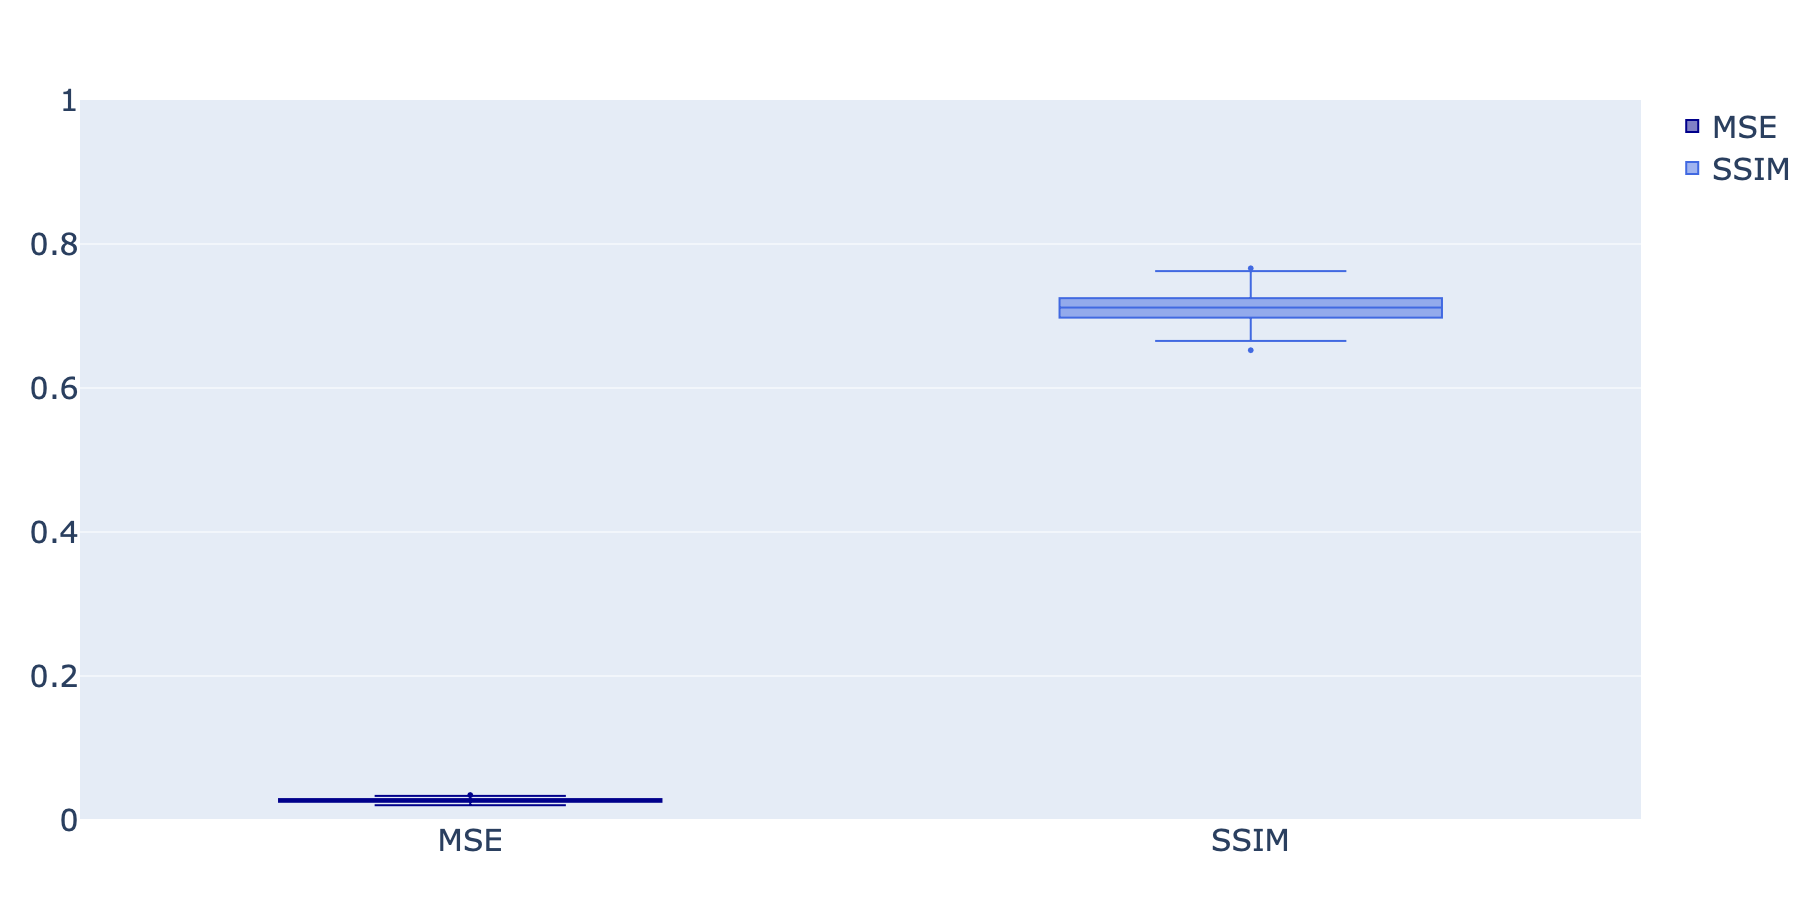

In [29]:
y0 = df.mse
y1 = df.ssim

fig = go.Figure()
fig.add_trace(go.Box(y=y0, name='MSE',
                marker_color = 'darkblue'))
fig.add_trace(go.Box(y=y1, name = 'SSIM',
                marker_color = 'royalblue'))
fig.update_layout(
    autosize=False,
    width=1200,
    height=900,
    yaxis=dict(
        # title_text="Y-axis Title",
        # ticktext=["Very long label", "long label", "3", "label"],
        # tickvals=,
        tickmode="array",
        titlefont=dict(size=30),
    ),
    yaxis_range=[0,1],
    font=dict(size=30),
)
fig.show(renderer="jupyterlab")
fig.write_image(model.RUN_DIR + f'boxplot_metrics_snr_{model.params["snr"]}.png')

# Rotate the weights

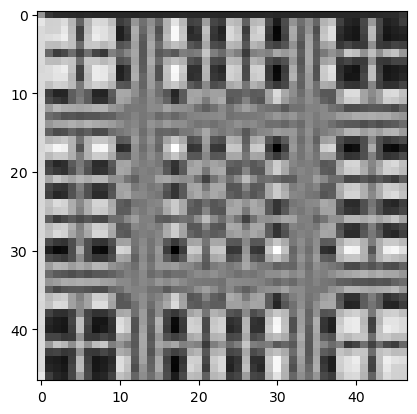

In [10]:
# Rotate the weights 180 degrees
w_rot90 = torch.rot90(torch.Tensor(weight_map), 1, [0, 1])
w_rot180 = torch.rot90(w_rot90, 1, [0, 1])
plt.imshow(w_rot180, cmap='gray')

In [12]:
np.linalg.norm(np.abs(w_rot180 - train_data.G),ord='fro')

46.22061846670332

In [14]:
pad = params['image_size']//2
padded_ex = torch.nn.functional.pad(loaders['train'].dataset[idx]['target'].unsqueeze(0), pad=(pad,pad,pad,pad), mode='circular')
padded_ex = padded_ex.squeeze(0).squeeze(0)

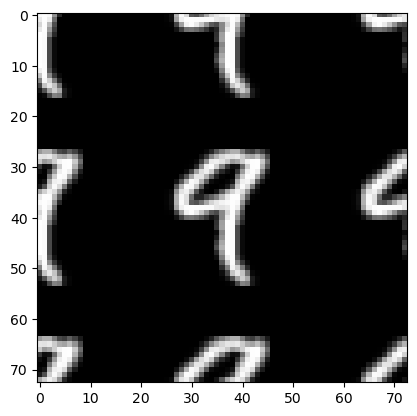

In [15]:
plt.imshow(padded_ex, cmap='gray')
plt.show()